# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assesment against the original mixed and isolated signals.

In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import importlib
from datetime import datetime

import audio_functions as af
import audio_models
import dataset

Using TensorFlow backend.


In [2]:
importlib.reload(audio_models)

<module 'audio_models' from '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/audio_models.py'>

### Get the variables and data ready

In [3]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0001
phase_weight = 0.005

#checkpoint = '52/52-10' #  Best U-net
checkpoint = '197/197-8'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Mixed'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Voice'
directory_c = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Background'

#directory_a = '/data/Speech_Data/LibriSpeech/Mixed/test-clean/1580/141083/'
#directory_b = '/data/Speech_Data/LibriSpeech/Voice/test-clean/1580/141083/'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b, directory_c)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, background_spec, mixed_audio, voice_audio, background_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)

mixed_input = mixed_spec[:, :, :-1, 2:4]
voice_input = voice_spec[:, :, :-1, 2:4]

data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [4]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_input, voice_input, mixed_phase, mixed_audio, 
                                    voice_audio, background_audio, 'unet', is_training, learning_rate, 
                                    'mag_phase', phase_weight, name='Magnitude_Model')
tf_config = tf.ConfigProto()
#tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(0)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

Creating model


In [5]:
model.voice_mask_network.decoder.output.shape

TensorShape([Dimension(None), Dimension(256), Dimension(512), Dimension(2)])

### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [6]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/197/197-8


### Run a batch

In [7]:
sess.run(pipe.initializer)
mix_inp, mix_phase, voice_inp, voice_est, mask, voice_wave, mix_wave = sess.run([model.mixed_input, 
                                                                                 model.mixed_phase, 
                                                                                 model.voice_input,
                                                                                 model.gen_voice, 
                                                                                 model.voice_mask, 
                                                                                 model.voice_audio, 
                                                                                 model.mixed_audio],
                                                                                {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_inp.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(voice_est[i, :, :, 1]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)


### Visualise and Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [51]:
i=0
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

1
65280


In [52]:
# Infer the background noise and background noise estimate by subtracting the voice and voice estimate from the mixture
# Normalise audio prior to subtraction
def normalise_audio(audio):
    norm_audio = 2*((audio - audio.min())/(audio.max()-audio.min())) - 1
    return norm_audio

for i in range (voice_wave.shape[0]):
    voice_wave[i,:,:] = normalise_audio(voice_wave[i,:,:])
    voice_est_wave[i,:,:] = normalise_audio(voice_est_wave[i,:,:])
    mix_wave[i,:,:] = normalise_audio(mix_wave[i,:,:])

bg_ref_wave = mix_wave - voice_wave
bg_est_wave = mix_wave - voice_est_wave

In [53]:
# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
mixed_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
nsdrs = np.empty((0, 2))
for i in range(len(voice_est_wave)):
    ref_sources.append(np.concatenate((voice_wave[i], bg_ref_wave[i]), axis=1))
    est_sources.append(np.concatenate((voice_est_wave[i], bg_est_wave[i]), axis=1))
    mixed_sources.append(np.concatenate((mix_wave[i], mix_wave[i]), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdr_mr, _, _, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, mixed_sources[i].T, compute_permutation=False)
    nsdr = sdr - sdr_mr
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)
    nsdrs = np.concatenate((nsdrs, np.expand_dims(nsdr, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars, '\nNSDR\n', nsdrs)

/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[7.65652138 9.04212911]] 
SIR
 [[15.63981215 13.64675565]] 
SAR
 [[ 8.52601391 11.07240367]] 
NSDR
 [[4.52524743 7.2835423 ]]


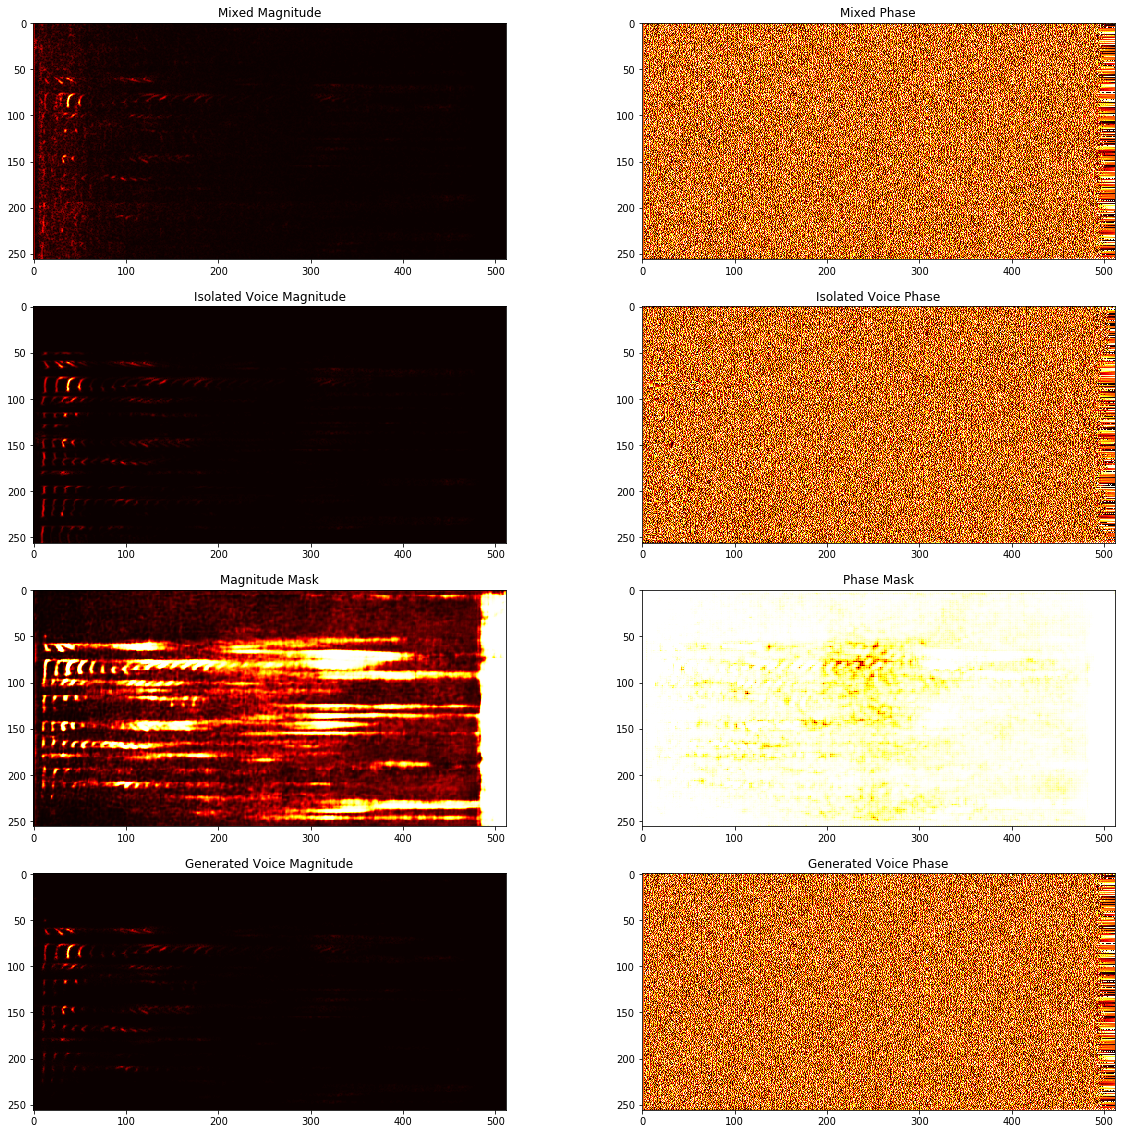

In [54]:
i=0

fig, ax = plt.subplots(4,2, figsize=(20,20))

ax[0,0].imshow(mix_inp[i,:,:,0])
ax[0,0].set_title('Mixed Magnitude')
ax[0,1].imshow(mix_inp[i,:,:,1])
ax[0,1].set_title('Mixed Phase')
ax[1,0].imshow(voice_inp[i,:,:,0])
ax[1,0].set_title('Isolated Voice Magnitude')
ax[1,1].imshow(voice_inp[i,:,:,1])
ax[1,1].set_title('Isolated Voice Phase')
ax[2,0].imshow(mask[i,:,:,0])
ax[2,0].set_title('Magnitude Mask')
ax[2,1].imshow(mask[i,:,:,1])
ax[2,1].set_title('Phase Mask')
ax[3,0].imshow(voice_est[i,:,:,0])
ax[3,0].set_title('Generated Voice Magnitude')
ax[3,1].imshow(voice_est[i,:,:,1])
ax[3,1].set_title('Generated Voice Phase')
#plt.savefig(os.path.join(folder, 'mag_phase_example_2.png'))
plt.show()

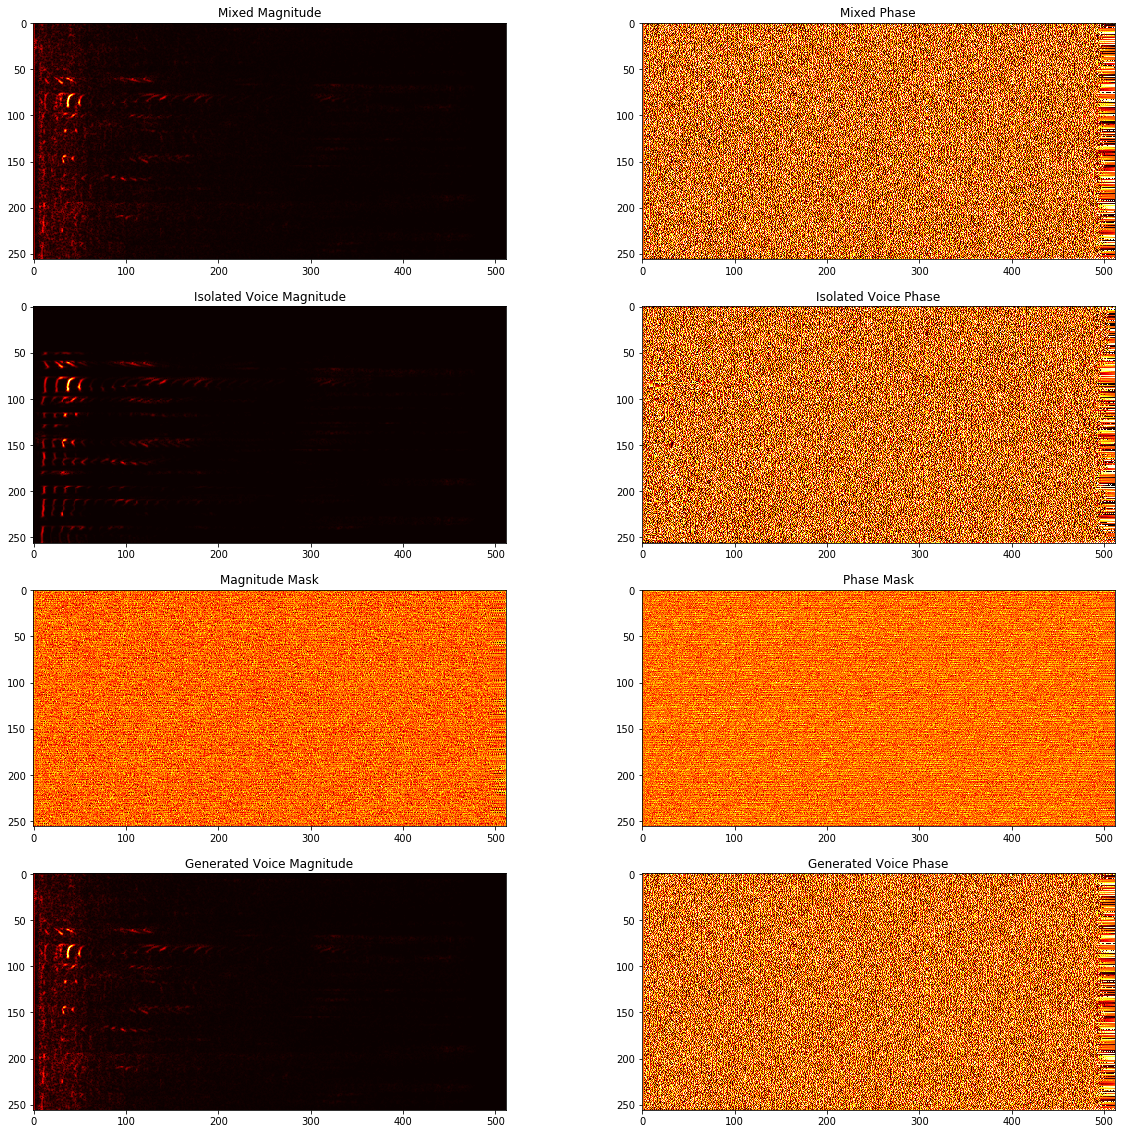

In [45]:
# Untrained

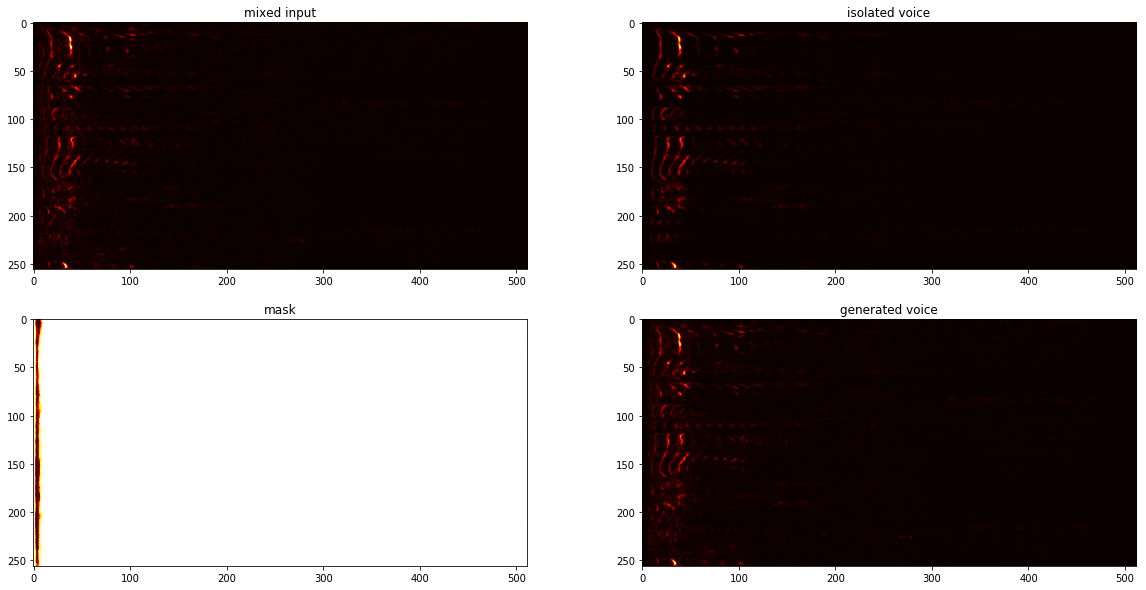

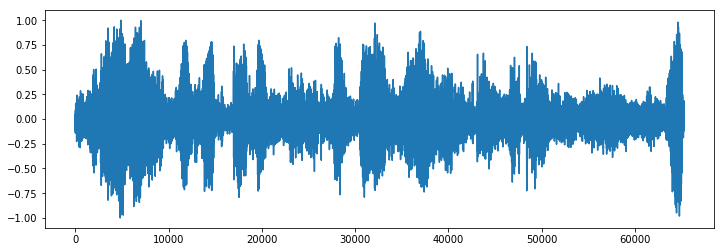

In [37]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

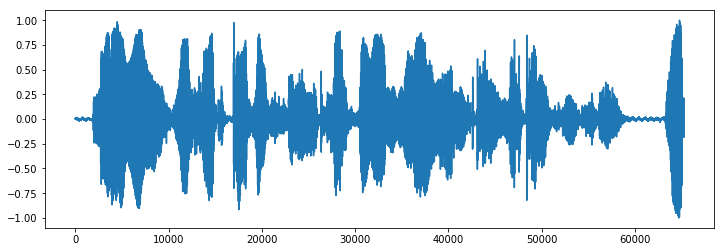

In [38]:
#  The original isolated voice
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

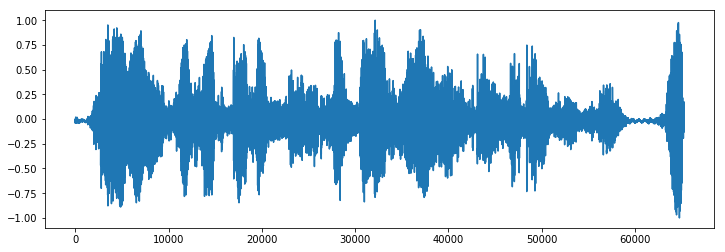

In [48]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

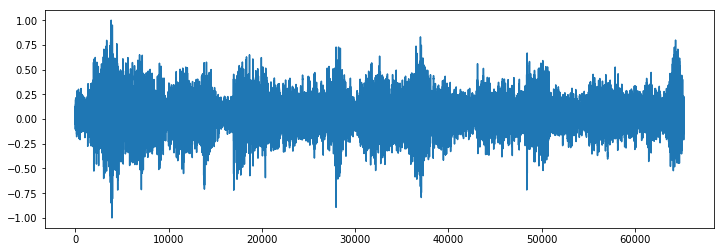

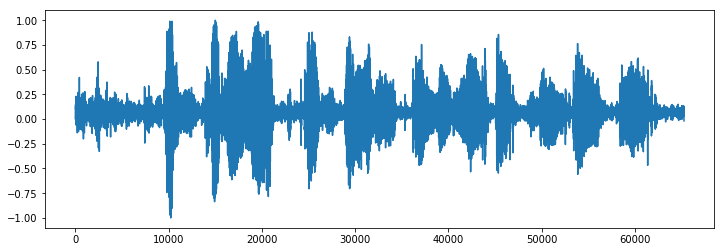

In [ ]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

In [ ]:
#  The background noise, by subtracting the voice on the waveform - doesn't seem to work
#print(metrics['mix'])
plt.figure(figsize=(12,4))
plt.plot(x,bg_ref_wave[i])
ipd.Audio(bg_ref_wave[i].T, rate=sample_rate)

In [ ]:
#  The background noise, by subtracting magnitude spectrograms
plt.figure(figsize=(12,4))
plt.plot(x,bg_est_wave[i])
ipd.Audio(bg_est_wave[i].T, rate=sample_rate)

In [26]:
mask.shape

(5, 256, 512, 2)

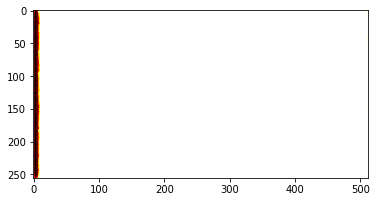

In [22]:
plt.imshow(mask[i,:,:,0])

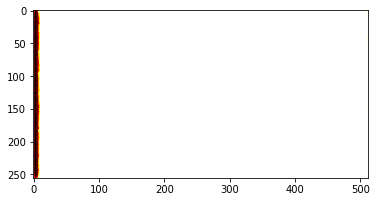

In [21]:
plt.imshow(mask[i,:,:,0])

In [6]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.now()))
epochs = 1
epoch = 0
epoch_cost = []
epoch_m_loss = []
epoch_p_loss = []
i = 0
while epoch < epochs:
    try:
        #_, cost = sess.run([model.train_op, model.cost], {model.is_training:True})
        _, cost, m_loss, p_loss = sess.run([model.train_op, model.cost, model.mag_loss, model.phase_loss], {model.is_training:True})
        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        epoch_m_loss.append(m_loss)
        epoch_p_loss.append(p_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        epoch_mean_m_loss = sum(epoch_m_loss)/len(epoch_m_loss)
        epoch_mean_p_loss = sum(epoch_p_loss)/len(epoch_p_loss)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        print('\tMean magnitude loss = {emml}\n\tMean phase loss = {empl}'.format(emml=epoch_mean_m_loss,
                                                                               empl=epoch_mean_p_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.now()))

start: 2018-11-19 10:46:59.924887
Epoch 0 finished. Mean cost = 0.0072400327771902084
	Mean magnitude loss = 0.0075388941913843155
	Mean phase loss = 0.006941171828657389
finish: 2018-11-19 10:47:02.036850


start: 2018-11-16 17:27:08.015648
Epoch 0 finished. Mean cost = 0.0028274506330490112
	Mean magnitude loss = 0.003137389663606882
	Mean phase loss = 0.002517511835321784
finish: 2018-11-16 17:27:09.892553


In [9]:
voice_est[0,:,:,1]

array([[ 3.1329997e+00,  5.8914523e-17,  4.0148927e-19, ...,
        -3.1343753e+00, -1.1994394e-15, -3.0801492e+00],
       [ 3.1402869e+00, -1.4031769e-01,  2.0762570e+00, ...,
        -1.5704798e+00,  3.1350114e+00,  1.5653932e+00],
       [ 3.1413910e+00,  4.3250382e-02, -1.0253849e+00, ...,
        -2.9144485e+00, -3.0002909e+00, -3.0644026e+00],
       ...,
       [ 3.1413524e+00, -2.1267866e-03,  1.4370159e+00, ...,
        -2.8369534e-01, -2.2214840e-01, -1.1995819e-01],
       [ 3.1404424e+00, -7.2141208e-02, -3.7850103e-01, ...,
         1.5526527e+00,  3.1254904e+00, -1.5638580e+00],
       [ 3.1383629e+00,  1.3096619e-03, -3.1272697e+00, ...,
         3.1179397e+00, -1.2178136e-02,  3.0468140e+00]], dtype=float32)

In [11]:
voice_inp[0,:,:,1]

array([[ 0.0000000e+00,  3.1415927e+00,  2.7992937e-17, ...,
        -3.1415927e+00,  1.7883210e-15,  3.1415927e+00],
       [ 3.1415927e+00, -4.6435422e-01, -3.0111234e+00, ...,
        -1.5718565e+00,  3.1408925e+00,  1.5704505e+00],
       [ 3.1415927e+00, -1.0183915e+00,  8.8480592e-01, ...,
         3.0991635e+00,  3.1320174e+00,  3.1288388e+00],
       ...,
       [ 3.1415927e+00,  4.9855453e-01, -2.8540895e+00, ...,
        -3.2488771e-02, -3.5815454e-01, -7.3092453e-02],
       [ 0.0000000e+00,  1.9046873e+00,  2.1193795e+00, ...,
         1.5511801e+00,  3.1284609e+00, -1.5773445e+00],
       [ 0.0000000e+00, -3.1367815e+00,  1.4596914e-02, ...,
         3.1231749e+00, -1.2260091e-02,  3.1354535e+00]], dtype=float32)

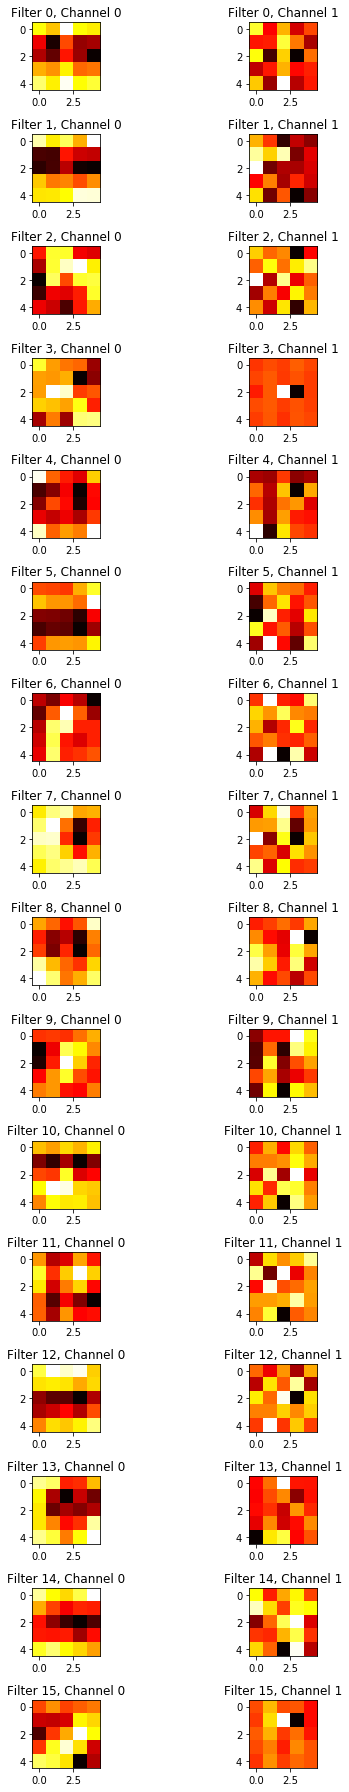

In [12]:
W = sess.run('Magnitude_Model/voice-mask-unet/encoder/layer-1/conv2d/kernel:0')
W2 = sess.run('Magnitude_Model/voice-mask-unet/encoder/layer-2/conv2d/kernel:0')
fig, ax = plt.subplots(16,2, figsize=(7,25))

for i in range(16):
    for j in range(2):
        ax[i,j].imshow(W[:,:,j,i])
        ax[i,j].set_title('Filter {i}, Channel {j}'.format(i=i, j=j))
plt.tight_layout()
plt.show()

In [28]:
layer_1_phase_mean = W[:,:,1,:].mean()
layer_1_phase_std = W[:,:,1,:].std()
layer_1_mag_mean = W[:,:,0,:].mean()
layer_1_mag_std = W[:,:,0,:].std()
layer_2_phase_mean = W2[:,:,1,:].mean()
layer_2_phase_std = W2[:,:,1,:].std()
layer_2_mag_mean = W2[:,:,0,:].mean()
layer_2_mag_std = W2[:,:,0,:].std()

weight_stats = np.array([[layer_1_phase_mean, layer_1_phase_std, layer_1_mag_mean, layer_1_mag_std],
                         [layer_2_phase_mean, layer_2_phase_std, layer_2_mag_mean, layer_2_mag_std]])

print(weight_stats)

[[-1.5781657e-06  5.3559081e-04 -3.2255348e-02  7.6378204e-02]
 [-1.1347249e-03  2.2883248e-02 -2.6270800e-04  2.2010736e-02]]


In [18]:
W[:,:,0,:].mean()

-0.032255348

In [19]:
W[:,:,1,:].std()

0.0005355908

In [20]:
W[:,:,0,:].std()

0.076378204

In [22]:
W2 = sess.run('Magnitude_Model/voice-mask-unet/encoder/layer-2/conv2d/kernel:0')

In [23]:
W2[:,:,1,:].mean()

-0.0011347249

In [24]:
W2[:,:,1,:].std()

0.022883248